In [8]:
import pynapple as nap
from pathlib import Path


# first iteration
# make list of paths
nwb_paths = [
    Path("/data_store2/neuropixels/nwb/NP113_B1/NP113_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP119_B1/NP119_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP128_B1/NP128_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP134_B2/NP134_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP147_B2/NP147_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP148_B2/NP148_B2.nwb"),
    Path("/data_store2/neuropixels/nwb/NP149_B1/NP149_B1.nwb"),
    Path("/data_store2/neuropixels/nwb/NP150_B1/NP150_B1.nwb"),
]

# make list of tumor ids and infiltrated ids
tumor_ids = [1, 0, 1, 0, 1, 0, 0, 1]
infiltrated_ids = [1, 0, 1, 0, 1, 0, 0, 0] # i.e. tumor, and not insular/opercular (will need to be confirmed)




# comparing tumor recording to non tumor recordings, treating opercular as tumor
# try comparing to actual non tumor
nwb_paths = [
   Path("/data_store2/neuropixels/nwb/NP113_B1/NP113_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP128_B1/NP128_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP137_B1/NP137_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP138_B1/NP138_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP147_B2/NP147_B2.nwb"),
   Path("/data_store2/neuropixels/nwb/NP150_B1/NP150_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP119_B1/NP119_B1.nwb"),
   Path("/data_store2/neuropixels/nwb/NP134_B2/NP134_B2.nwb"),
   Path("/data_store2/neuropixels/nwb/NP148_B2/NP148_B2.nwb"),
   Path("/data_store2/neuropixels/nwb/NP149_B1/NP149_B1.nwb"),
]

# make list of tumor ids and infiltrated id
tumor_ids = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0] # need to confirm the opercular ones are in fact not in tumor
infiltrated_ids = tumor_ids # just treat opercular as the non tumor controls
insertion_ids = [
    0, 0, 0, # NP113
    0, 1, # NP128
    1, 0, # NP137
    1, 0, # NP138
    1, # NP147
    1, 0, # NP150
    0, 0, 0, # NP119
    0, 0, 0, 0, # NP134
    0, # NP148
    0 # NP149
    ] # 0 = frontal, 1 = temporal

In [12]:
import fnmatch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.linalg import norm
from scipy.stats import kstest

# define variables to save out from loop
bin_counts_list = []
first_assembly_member_bin_counts_list = []
all_assembly_member_bin_counts_list = []
sparsity_list_list = []
spatial_spread_list = []
bin_fx_list = []
cell_yield_list = []
assembly_yield_list = []
tumor_id_list = []
infiltrated_id_list = []
i_save = 0

# loop through all nwb files
for i in range(len(nwb_paths)):
    data = nap.load_file(nwb_paths[i])
    keys = data.keys()

    # find the spike TsGroup objects, number various based on recording apparatus
    template = "*imec*"
    keys = [key for key in keys if fnmatch.fnmatch(key, template)]
    # Preferentially select keys containing 'KS4'; if none, use all keys
    ks_keys = [key for key in keys if "KS4" in key]
    if ks_keys:
        keys = ks_keys
    # Preferentially select keys containing 'Th='; if none, use all keys
    th_keys = [key for key in keys if "Th=" in key]
    if th_keys:
        keys = th_keys
    template = "*sentgen*" 
    keys = [key for key in keys if not fnmatch.fnmatch(key, template)]
    
    # loop through all individual probes
    for s in range(len(keys)):
        spike_times = data[keys[s]]
        # print(spike_times)
        
        # 1. filter to good neurons
        firingRates_all = spike_times.metadata["rate"]
        task_times = data["TaskTimes"]
        beh_epochs = nap.IntervalSet(start=task_times.start, end=task_times.end)
        spike_times_beh = spike_times.restrict(beh_epochs)
        firingRates_beh = spike_times_beh.metadata["rate"]

        # calculate ks stats
        start_time = task_times.start
        end_time = task_times.end
        ks_stats = np.zeros(len(spike_times))
        ks_pvals = np.zeros(len(spike_times))
        for u in range(len(spike_times)):
            # get spike times for this unit
            test = spike_times[u].as_series().index.values

            # The null hypothesis is that the spike times are uniformly distributed between start_time and end_time
            if len(test) > 1:
                min_time = start_time[0]
                max_time = end_time[-1]
                # Normalize spike times to [0, 1] for KS test against uniform
                normalized_spike_times = (test - min_time) / (max_time - min_time)
                ks_result = kstest(normalized_spike_times, 'uniform')
                ks_stats[u] = ks_result.statistic
                ks_pvals[u] = ks_result.pvalue
            else:
                ks_stats[u] = np.nan
                ks_pvals[u] = np.nan

        # now do ISI calculation
        violationThreshold = 3/1000 #for 3 ms isi refractory period, what used before, middle of range that kilosort cites
        violationPct = np.zeros(len(spike_times))
        for u in range(len(spike_times)):
            unit = spike_times[u]
            unit = unit.as_series().index
            if len(unit) < 100:
                violationPct[u] = 1 
            else:
                isi = unit.diff()[1:len(unit)]
                violations = np.where(isi<violationThreshold)
                violations = np.array(violations)
                violationPct[u] = violations.size/len(isi)

        # now apply masks
        if "KSLabel" in spike_times.metadata:
            KSLabels = spike_times.metadata["KSLabel"]
        else:
            KSLabels = spike_times.metadata["quality"]
        firingRates = firingRates_beh
        mask1 = violationPct<3/100 # throwing out neurons with > 3% isi violations with isi = 3 ms; lose quite a bit with 5 ms esp when including cdf stats
        mask2 = firingRates>0.5 # firing rate > 0.5 ms during all behavior epochs
        mask3 = KSLabels!="noise" # not noise per auto label
        mask4 = ks_stats < 0.3 # KS stat < 0.3 (stability across recording)
        mask = mask1 & mask2 & mask3 & mask4
        indicesFinal = firingRates.index[mask]
        spike_times_good = spike_times_beh[indicesFinal]
        print(f"Number of good neurons: {len(spike_times_good)}")



        # 2.  make spike rate matrix
        # now restrict spike times to the good neurons
        spike_times_good = spike_times[indicesFinal]
        # print(spike_times_good)

        # make spike count matrix
        timescale = 25/1000;
        spikeCountMatrix = spike_times_good.count(bin_size=timescale)
        spikeCountMatrix = spikeCountMatrix.values # matrix in spike counts
        firingRateMatrix = spikeCountMatrix/timescale # matrix in Hz
        firingRateMatrix = stats.zscore(firingRateMatrix, axis=0) # zscore across time (within neuron)



        # 3. run PCA to get first pass assembly patterns
        pca = PCA()

        # fit and transform data
        # note don't have to center bc each row is zscores so center of matrix is 0
        firingRateMatrix_pca = pca.fit_transform(firingRateMatrix)
        eigenvalues = pca.explained_variance_ 

        # calculate the upperbound of the Marchenko-Pastur law, eigenvalues above the 
        # upper bound are patterns that will be considered "assemblies"
        upperbound = (1+np.sqrt(firingRateMatrix.shape[1]/firingRateMatrix.shape[0]))**2

        # classic definition
        assemblyIndices = np.where(eigenvalues>upperbound)

        # more stringent definition
        # assemblyIndices = np.where((eigenvalues > upperbound) & (eigenvalues > np.mean(eigenvalues) + np.std(eigenvalues) * 2))

        # save assembly eigenvalues
        assemblyEigenvalues = eigenvalues[assemblyIndices]



        # 4. orthogonalize the assembly patterns with ICA
        # only get the assembly pca patterns
        n_pcs = len(assemblyEigenvalues) # only want the above threshold patterns
        pc_vectors = pca.components_[:n_pcs, :]

        # project the assembly pca patterns onto the firing rate matrix
        projections = firingRateMatrix @ pc_vectors.T

        # define and run the ICA
        if n_pcs > 0:
            fastica = FastICA(
                n_components=n_pcs,
                algorithm='parallel',
                whiten='unit-variance',
                max_iter=500,
                tol=1e-7,
                random_state=1
            )
            ica_components = fastica.fit_transform(projections)

            # get mixing and unmixing matrices
            mixing_matrix = fastica.mixing_
            unmixing_matrix = fastica.components_

            # 5. project the assembly patterns back to the original feature space (neurons)
            ica_assembly_patterns = unmixing_matrix @ pc_vectors  # Shape: (n_pcs, n_features)

            # define members, save out unit vectors and bool in matrices
            ap_norm_matrix = ica_assembly_patterns
            ap_norm_member = np.zeros(ica_assembly_patterns.shape)
            for ii in range(n_pcs):
                ap = ica_assembly_patterns[ii,:]
                ap_norm = ap/norm(ap)
                maxW = max(ap_norm);
                minW = min(ap_norm);
                if abs(minW) > maxW:
                    ap_norm = ap_norm*-1
                ap_norm_matrix[ii,:] = ap_norm
                threshold = np.mean(ap_norm) + np.std(ap_norm) * 2
                for c in range(len(ap)):
                    if ap_norm[c] > threshold:
                        ap_norm_member[ii,c] = 1

            # 6. split neurons into depth bins and visualize         
            probeDepth = 6000; # this is a dummy as actual value is not on the spreadsheet, this is about average

            str1 = keys[s]
            str2 = str1[0:11].replace("NP","catgt_NP")
            str3 = str1[0:8]

            positions = np.load(f'/data_store2/neuropixels/preproc/{str3}/kilosort/{str2}/{str1}/spike_positions.npy')
            clusters = np.load(f'/data_store2/neuropixels/preproc/{str3}/kilosort/{str2}/{str1}/spike_clusters.npy')

            # get the mean depth for each unit
            y_vals = np.zeros(len(indicesFinal));
            ct = 0
            for ii in indicesFinal: 
                y_vals[ct] = np.mean(positions[np.where(clusters==ii)], axis=0)[1]
                ct += 1

            depths = probeDepth - y_vals;
            depthBins = np.linspace(np.min(depths)-1,np.max(depths)+1,7) # just space it from min to max since don't know the insertion depth or cortical thickness

            # Assign each depth to a depth bin (0-based index)
            depth_bin_indices = np.digitize(depths, depthBins)

            # Calculate the fraction of neurons in each depth bin
            n_bins = 6 # len(np.unique(depth_bin_indices)), hard code in case a session doesn't have a neuron in a given bin which happens in lower yield recordings
            bin_counts = [(depth_bin_indices == b).sum() for b in range(1, n_bins+1)]
            total_neurons = len(depth_bin_indices)
            fraction_per_bin = np.array(bin_counts) / total_neurons

            # Calculate the percentage of total neurons that are member neurons to at least one assembly
            member_mask = np.any(ap_norm_member == 1, axis=0)
            n_member_neurons = np.sum(member_mask)
            percent_member_neurons = n_member_neurons / total_neurons

            # Get the indices of member neurons in the first assembly pattern (row 0)
            first_assembly_member_mask = ap_norm_member[0, :] == 1
            # Get the depth bins for these member neurons
            first_assembly_member_depth_bins = depth_bin_indices[first_assembly_member_mask]
            # Count the number of member neurons in each bin (bins are 1-indexed)
            first_assembly_member_bin_counts = [(first_assembly_member_depth_bins == b).sum() for b in range(1, n_bins+1)]

            # get a metric of the spatial spread of first assembly members
            num_bins_with_first_assembly_member = np.sum(np.array(first_assembly_member_bin_counts) > 0)

            # Get the depth bins for all assembly member neurons (across all assemblies)
            all_member_depth_bins = depth_bin_indices[member_mask]
            # Count the number of member neurons in each bin (bins are 1-indexed)
            all_member_bin_counts = [(all_member_depth_bins == b).sum() for b in range(1, n_bins+1)]

            # Calculate sparsity metric for each assembly
            sparsity_list = []
            sparsity_key = []
            for ap in range(len(ap_norm_matrix)):
                w = np.array(ap_norm_matrix[ap,:])
                n = w.size
                numerator = np.sqrt(n) - np.sum(np.abs(w))
                denominator = np.sqrt(n) - 1
                sparsity = 1 - numerator / denominator if denominator != 0 else np.nan
                sparsity_list.append(sparsity)
        else:
            bin_counts = [0, 0, 0, 0, 0, 0]
            first_assembly_member_bin_counts = [0, 0, 0, 0, 0, 0]
            all_member_bin_counts = [0, 0, 0, 0, 0, 0]
            sparsity_list = []
            num_bins_with_first_assembly_member = []
            fraction_per_bin = []
        # print("Sparsity metric for each assembly:", sparsity_list)

        # 7. save out variables
        bin_counts_list.append(bin_counts)
        first_assembly_member_bin_counts_list.append(first_assembly_member_bin_counts)
        all_assembly_member_bin_counts_list.append(all_member_bin_counts)
        sparsity_list_list.append(sparsity_list)
        spatial_spread_list.append(num_bins_with_first_assembly_member)
        bin_fx_list.append(fraction_per_bin)
        cell_yield_list.append(len(indicesFinal))
        assembly_yield_list.append(len(assemblyEigenvalues))
        tumor_id_list.append(tumor_ids[i])
        infiltrated_id_list.append(infiltrated_ids[i])
        i_save += 1


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: Some starts and ends are equal. Removing 1 microsecond!
  data = nap.IntervalSet(df)
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 204
Number of good neurons: 217
Number of good neurons: 151


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 29


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 12


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 6


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 36


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 4


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 10


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 61


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 15


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 10


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: DataFrame is not sorted by start times. Sorting it.
  data = nap.IntervalSet(df)
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 104
Number of good neurons: 201


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 269


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 71


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 93


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(


Number of good neurons: 50
Number of good neurons: 60


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 31


/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:60: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/base_class.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/userdata/ekato/miniforge3/envs/se2nwb/lib/python3.10/site-packages/pynapple/core/metadata_class.py:188: UserWarning: Metadata name 'Task name' contains a special character, and cannot be accessed as an attribute. Use 'get_info()' or key indexing to access metadata.
  warnings.warn(


Number of good neurons: 32


In [31]:
# debugging cell
print(len(sparsity_list_list))
print(assemblyEigenvalues)
print(n_pcs)
print(len(assemblyEigenvalues))
print(len(ap_norm_matrix))
print(sparsity_list)
print(sparsity_list_list)


3
[3.72891112 2.72821532 1.84938614 1.76036009 1.59177004 1.45861862
 1.41008941 1.31115079 1.29815129 1.26941642 1.25582546 1.22969563
 1.19047359 1.16894212 1.1451111  1.13291578 1.12404333 1.11162091
 1.10152396 1.09759534]
20
20
20
[0.6053225463682904, 0.609463000819997, 0.5796612283866647, 0.6154615718779803, 0.7309683546604522, 0.6786798212645313, 0.5476560053159901, 0.6453775248750722, 0.5902233030230928, 0.594292071019715, 0.6307745361073065, 0.7403727688104005, 0.6692996063400363, 0.6495589545468258, 0.720745091944909, 0.6550757951699597, 0.6375303037815905, 0.7192816463896672, 0.6124272356236561, 0.698187190281609]
[[0.5646736229387184, 0.7028241957000086, 0.5730303993548624, 0.6159050877894066, 0.7325056680278622, 0.6579315744534275, 0.6793214343705991, 0.6554585871883086, 0.6954750494867925, 0.5671486927313824, 0.7367605466290199, 0.5010462585507367, 0.7071684488671011, 0.7128043862543947, 0.6609533225213395, 0.7294942644816549, 0.7233397813002032, 0.6322796057751241, 0.633

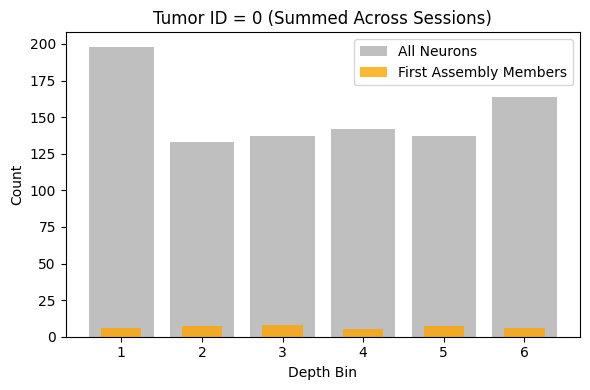

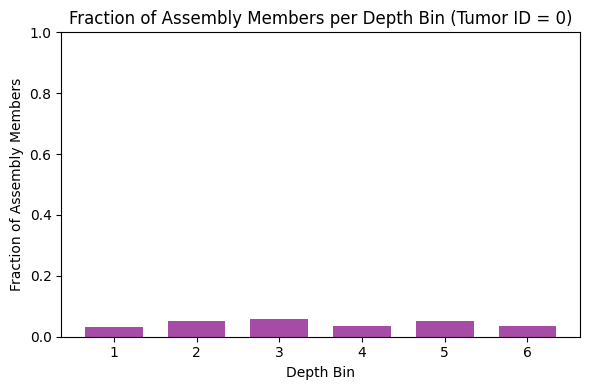

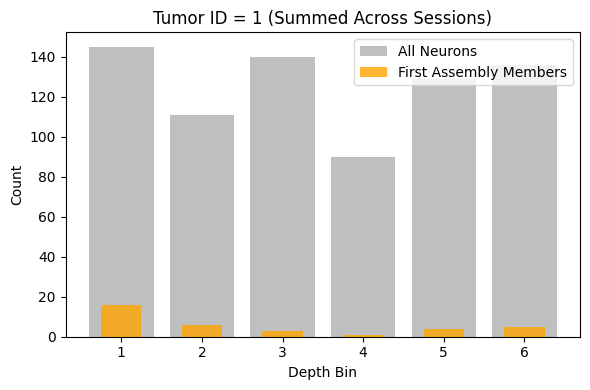

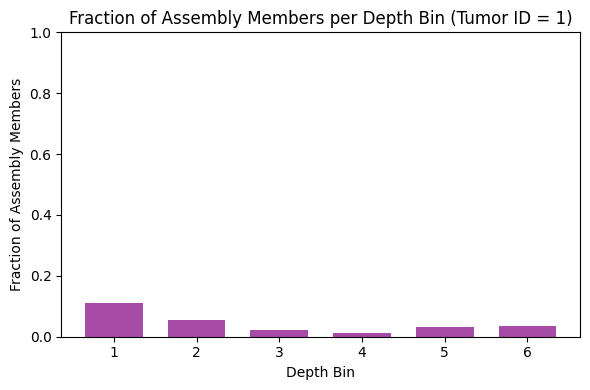

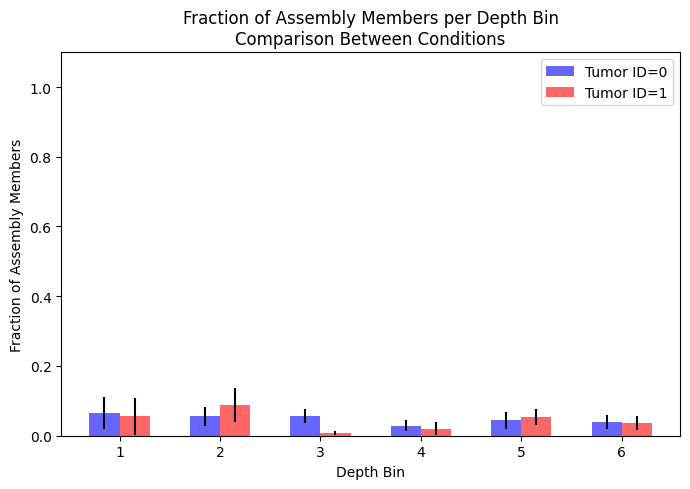

Depth Bin 1: t=0.12, p=0.9053
Depth Bin 2: t=-0.57, p=0.5801
Depth Bin 3: t=2.22, p=0.0525
Depth Bin 4: t=0.34, p=0.7420
Depth Bin 5: t=-0.26, p=0.7974
Depth Bin 6: t=0.11, p=0.9161


In [17]:
# now do some analysis on the saved out variables
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Convert lists to numpy arrays for easier indexing
bin_counts_arr = np.array(bin_counts_list)  # shape: (n_sessions, n_bins)

# note: can change this from first_ to all_ to compare just first or all so that don't have to duplicate code
first_assembly_member_bin_counts_arr = np.array(first_assembly_member_bin_counts_list)  # shape: (n_sessions, n_bins)

# note: can change this from tumor_ to infiltrated_ to compare just tumor or infiltrated so that don't have to duplicate code
tumor_id_arr = np.array(infiltrated_id_list)

# Get unique tumor_id conditions (should be 0 and 1)
unique_tumor_ids = np.unique(tumor_id_arr)

# Store per-session fractions for stats
fraction_per_session = {}

for tid in unique_tumor_ids:
    # Find indices for this tumor_id
    idxs = np.where(tumor_id_arr == tid)[0]
    if len(idxs) == 0:
        continue

    # Sum across all sessions for this tumor_id
    summed_bin_counts = np.sum(bin_counts_arr[idxs], axis=0)
    summed_first_assembly_member_bin_counts = np.sum(first_assembly_member_bin_counts_arr[idxs], axis=0)

    plt.figure(figsize=(6,4))
    bins = np.arange(1, len(summed_bin_counts)+2) - 0.5  # bin edges for bar plots

    # Plot all neuron bin counts (background)
    plt.bar(np.arange(1, len(summed_bin_counts)+1), summed_bin_counts, 
            width=0.8, color='gray', alpha=0.5, label='All Neurons')

    # Overlay first assembly member bin counts
    plt.bar(np.arange(1, len(summed_first_assembly_member_bin_counts)+1), 
            summed_first_assembly_member_bin_counts, 
            width=0.5, color='orange', alpha=0.8, label='First Assembly Members')

    plt.xlabel('Depth Bin')
    plt.ylabel('Count')
    plt.title(f'Tumor ID = {tid} (Summed Across Sessions)')
    plt.xticks(np.arange(1, len(summed_bin_counts)+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Fraction plot ---
    # To avoid division by zero, mask bins with zero total neurons
    with np.errstate(divide='ignore', invalid='ignore'):
        fraction = np.zeros_like(summed_first_assembly_member_bin_counts, dtype=float)
        mask = summed_bin_counts > 0
        fraction[mask] = summed_first_assembly_member_bin_counts[mask] / summed_bin_counts[mask]
        fraction[~mask] = np.nan  # or 0, but nan is more explicit

    plt.figure(figsize=(6,4))
    plt.bar(np.arange(1, len(fraction)+1), fraction, width=0.7, color='purple', alpha=0.7)
    plt.xlabel('Depth Bin')
    plt.ylabel('Fraction of Assembly Members')
    plt.title(f'Fraction of Assembly Members per Depth Bin (Tumor ID = {tid})')
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(fraction)+1))
    plt.tight_layout()
    plt.show()

    # Store per-session fractions for stats
    # shape: (n_sessions_in_group, n_bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_session_fraction = np.zeros_like(first_assembly_member_bin_counts_arr[idxs], dtype=float)
        mask = bin_counts_arr[idxs] > 0
        per_session_fraction[mask] = first_assembly_member_bin_counts_arr[idxs][mask] / bin_counts_arr[idxs][mask]
        per_session_fraction[~mask] = np.nan
    fraction_per_session[tid] = per_session_fraction

# --- Statistical comparison between conditions for each depth bin ---
# Only proceed if both conditions are present
if len(unique_tumor_ids) == 2:
    tid0, tid1 = unique_tumor_ids
    frac0 = fraction_per_session[tid0]  # shape: (n_sessions0, n_bins)
    frac1 = fraction_per_session[tid1]  # shape: (n_sessions1, n_bins)
    n_bins = frac0.shape[1]

    pvals = []
    tvals = []
    for b in range(n_bins):
        # Remove nan values for t-test
        x0 = frac0[:, b]
        x1 = frac1[:, b]
        x0 = x0[~np.isnan(x0)]
        x1 = x1[~np.isnan(x1)]
        if len(x0) > 1 and len(x1) > 1:
            tval, pval = ttest_ind(x0, x1, equal_var=False, nan_policy='omit')
        else:
            tval, pval = np.nan, np.nan
        tvals.append(tval)
        pvals.append(pval)

    # Plot the mean and SEM for each group, with significance stars
    def sem(x):
        return np.nanstd(x, axis=0) / np.sqrt(np.sum(~np.isnan(x), axis=0))

    means0 = np.nanmean(frac0, axis=0)
    sems0 = sem(frac0)
    means1 = np.nanmean(frac1, axis=0)
    sems1 = sem(frac1)

    plt.figure(figsize=(7,5))
    x = np.arange(1, n_bins+1)
    plt.bar(x-0.15, means0, width=0.3, yerr=sems0, color='blue', alpha=0.6, label=f'Tumor ID={tid0}')
    plt.bar(x+0.15, means1, width=0.3, yerr=sems1, color='red', alpha=0.6, label=f'Tumor ID={tid1}')

    # Add significance stars
    for b in range(n_bins):
        if np.isnan(pvals[b]):
            continue
        if pvals[b] < 0.001:
            star = '***'
        elif pvals[b] < 0.01:
            star = '**'
        elif pvals[b] < 0.05:
            star = '*'
        else:
            star = ''
        if star:
            y_max = max(means0[b]+sems0[b], means1[b]+sems1[b])
            plt.text(x[b], y_max + 0.05, star, ha='center', va='bottom', color='k', fontsize=14)

    plt.xlabel('Depth Bin')
    plt.ylabel('Fraction of Assembly Members')
    plt.title('Fraction of Assembly Members per Depth Bin\nComparison Between Conditions')
    plt.ylim(0, 1.1)
    plt.xticks(x)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print p-values for each bin
    for b in range(n_bins):
        print(f"Depth Bin {b+1}: t={tvals[b]:.2f}, p={pvals[b]:.4f}")





n0=9, mean0=0.675 ± 0.045
n1=11, mean1=0.624 ± 0.137
t=1.01, p=0.3249


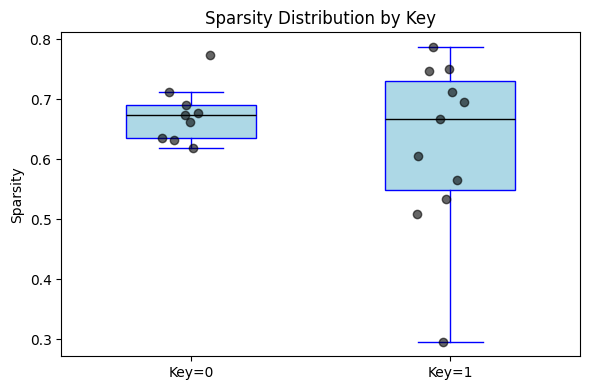

In [15]:
# Sparsity analysis using all values in sparsity_list_list

# Flatten all sparsity values and corresponding keys
all_sparsity = []
all_keys = []

# for sparsity_vals, key in zip(sparsity_list_list, tumor_ids):
#     all_sparsity.extend(sparsity_vals)
#     all_keys.extend([key] * len(sparsity_vals))

# do this for only first assembly
for ii in range(len(sparsity_list_list)):
    if sparsity_list_list and len(sparsity_list_list[ii]) > 0:
        all_sparsity.append(sparsity_list_list[ii][0])
        all_keys.append(infiltrated_id_list[ii])

all_sparsity = np.array(all_sparsity)
all_keys = np.array(all_keys)

# Split by key
sparsity_0 = all_sparsity[all_keys == 0]
sparsity_1 = all_sparsity[all_keys == 1]

# Print summary statistics
print(f"n0={len(sparsity_0)}, mean0={np.mean(sparsity_0):.3f} ± {np.std(sparsity_0):.3f}")
print(f"n1={len(sparsity_1)}, mean1={np.mean(sparsity_1):.3f} ± {np.std(sparsity_1):.3f}")

# Run statistical test (two-sample t-test)
from scipy.stats import ttest_ind
tval, pval = ttest_ind(sparsity_0, sparsity_1, nan_policy='omit')
print(f"t={tval:.2f}, p={pval:.4f}")

# Box and whisker plot with all individual data points overlaid
plt.figure(figsize=(6,4))
data = [sparsity_0, sparsity_1]
positions = [1, 2]
plt.boxplot(
    data,
    positions=positions,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(markerfacecolor='blue', marker='', markersize=5, alpha=0.5),
    widths=0.5
)

# Overlay all individual data points (jittered)
for i, y in enumerate(data):
    x = np.random.normal(positions[i], 0.06, size=len(y))  # jitter
    plt.plot(x, y, 'o', color='k', alpha=0.6, markersize=6)

plt.ylabel('Sparsity')
plt.title('Sparsity Distribution by Key')
plt.xticks(positions, ['Key=0', 'Key=1'])
plt.tight_layout()
plt.show()


In [16]:
# calculate spatial spread metric
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Convert lists to numpy arrays for easier indexing
spatial_spread_arr = np.array(spatial_spread_list)
tumor_id_arr = np.array(infiltrated_id_list)

# Split by tumor id
spread_0 = spatial_spread_arr[tumor_id_arr == 0]
spread_1 = spatial_spread_arr[tumor_id_arr == 1]

# Print summary statistics
print(f"n0={len(spread_0)}, mean0={np.mean(spread_0):.3f} ± {np.std(spread_0):.3f}")
print(f"n1={len(spread_1)}, mean1={np.mean(spread_1):.3f} ± {np.std(spread_1):.3f}")

# Run statistical test (two-sample t-test)
tval, pval = ttest_ind(spread_0, spread_1, nan_policy='omit')
print(f"t={tval:.2f}, p={pval:.4f}")

# Box and whisker plot with all individual data points overlaid
plt.figure(figsize=(6,4))
data = [spread_0, spread_1]
positions = [1, 2]
plt.boxplot(
    data,
    positions=positions,
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='green'),
    capprops=dict(color='green'),
    flierprops=dict(markerfacecolor='green', marker='', markersize=5, alpha=0.5),
    widths=0.5
)

# Overlay all individual data points (jittered)
for i, y in enumerate(data):
    x = np.random.normal(positions[i], 0.06, size=len(y))  # jitter
    plt.plot(x, y, 'o', color='k', alpha=0.6, markersize=6)

plt.ylabel('Spatial Spread')
plt.title('Spatial Spread by Tumor ID')
plt.xticks(positions, ['Tumor ID=0', 'Tumor ID=1'])
plt.tight_layout()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21,) + inhomogeneous part.